# Initialize Notebook

In [48]:
import re
import itertools
import numpy as np
import scipy.spatial.distance
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
from collections import Counter
from deep_translator import GoogleTranslator, PonsTranslator, LibreTranslator
from mtranslate import translate as mtranslate
from translate import Translator
from transformers import MarianMTModel, MarianTokenizer
import torch
import os
import ast

In [34]:
## ONLY RUN IF MODEL FILE IS NOT ALREADY COMPUTED ##
class Model:
    """Create model to compute DAT"""

    def __init__(self, model="glove.840B.300d.txt", dictionary="words.txt", pattern="^[a-z][a-z-]*[a-z]$"):
        """Join model and words matching pattern in dictionary"""

        # Keep unique words matching pattern from file
        words = set()
        with open(dictionary, "r", encoding="utf8") as f:
            for line in f:
                if re.match(pattern, line):
                    words.add(line.rstrip("\n"))

        # Join words with model
        vectors = {}
        with open(model, "r", encoding="utf8") as f:
            for line in f:
                tokens = line.split(" ")
                word = tokens[0]
                if word in words:
                    vector = np.asarray(tokens[1:], "float32")
                    vectors[word] = vector
        self.vectors = vectors


    def validate(self, word):
        """Clean up word and find best candidate to use"""

        # Strip unwanted characters
        clean = re.sub(r"[^a-zA-Z- ]+", "", word).strip().lower()
        if len(clean) <= 1:
            return None # Word too short

        # Generate candidates for possible compound words
        # "valid" -> ["valid"]
        # "cul de sac" -> ["cul-de-sac", "culdesac"]
        # "top-hat" -> ["top-hat", "tophat"]
        candidates = []
        if " " in clean:
            candidates.append(re.sub(r" +", "-", clean))
            candidates.append(re.sub(r" +", "", clean))
        else:
            candidates.append(clean)
            if "-" in clean:
                candidates.append(re.sub(r"-+", "", clean))
        for cand in candidates:
            if cand in self.vectors:
                return cand # Return first word that is in model
        return None # Could not find valid word


    def distance(self, word1, word2):
        """Compute cosine distance (0 to 2) between two words"""

        return scipy.spatial.distance.cosine(self.vectors.get(word1), self.vectors.get(word2))


    def dat(self, words, minimum=7):
        """Compute DAT score"""
        # Keep only valid unique words
        uniques = []
        for word in words:
            valid = self.validate(word)
            if valid and valid not in uniques:
                uniques.append(valid)

        # Keep subset of words
        if len(uniques) >= minimum:
            subset = uniques[:minimum]
        else:
            return None # Not enough valid words

        # Compute distances between each pair of words
        distances = []
        for word1, word2 in itertools.combinations(subset, 2):
            dist = self.distance(word1, word2)
            distances.append(dist)

        # Compute the DAT score (average semantic distance multiplied by 100)
        return (sum(distances) / len(distances)) * 100
    
# GloVe model from https://nlp.stanford.edu/projects/glove/
model = Model("glove.840B.300d.txt", "words.txt")

# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [49]:
## LOAD MODEL ##

class Model:
    """Create model to compute DAT"""

    def __init__(self, model="glove.840B.300d.txt", dictionary="words.txt", pattern="^[a-z][a-z-]*[a-z]$"):
        """Join model and words matching pattern in dictionary"""

        # Keep unique words matching pattern from file
        words = set()
        with open(dictionary, "r", encoding="utf8") as f:
            for line in f:
                if re.match(pattern, line):
                    words.add(line.rstrip("\n"))

        # Join words with model
        vectors = {}
        with open(model, "r", encoding="utf8") as f:
            for line in f:
                tokens = line.split(" ")
                word = tokens[0]
                if word in words:
                    vector = np.asarray(tokens[1:], "float32")
                    vectors[word] = vector
        self.vectors = vectors


    def validate(self, word):
        """Clean up word and find best candidate to use"""

        # Strip unwanted characters
        clean = re.sub(r"[^a-zA-Z- ]+", "", word).strip().lower()
        if len(clean) <= 1:
            return None # Word too short

        # Generate candidates for possible compound words
        # "valid" -> ["valid"]
        # "cul de sac" -> ["cul-de-sac", "culdesac"]
        # "top-hat" -> ["top-hat", "tophat"]
        candidates = []
        if " " in clean:
            candidates.append(re.sub(r" +", "-", clean))
            candidates.append(re.sub(r" +", "", clean))
        else:
            candidates.append(clean)
            if "-" in clean:
                candidates.append(re.sub(r"-+", "", clean))
        for cand in candidates:
            if cand in self.vectors:
                return cand # Return first word that is in model
        return None # Could not find valid word


    def distance(self, word1, word2):
        """Compute cosine distance (0 to 2) between two words"""

        return scipy.spatial.distance.cosine(self.vectors.get(word1), self.vectors.get(word2))


    def dat(self, words, minimum=7):
        """Compute DAT score"""
        # Keep only valid unique words
        uniques = []
        for word in words:
            valid = self.validate(word)
            if valid and valid not in uniques:
                uniques.append(valid)

        # Keep subset of words
        if len(uniques) >= minimum:
            subset = uniques[:minimum]
        else:
            return None # Not enough valid words

        # Compute distances between each pair of words
        distances = []
        for word1, word2 in itertools.combinations(subset, 2):
            dist = self.distance(word1, word2)
            distances.append(dist)

        # Compute the DAT score (average semantic distance multiplied by 100)
        return (sum(distances) / len(distances)) * 100
    
with open('G:/Meine Ablage/Uni BAE/Master Thesis/Analysis/divergent-association-task-main/model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load Data

In [50]:
# Load the CSV file from experiment survey 
df = pd.read_csv('./data/experiment_raw_data.csv')

In [52]:
# Select specific columns
selected_columns = df[['CASE', 'LANGUAGE', 'A501x01', 'A501x02', 'A501x03', 'A501x04', 'A501x05', 'A501x06', 'A501x07', 'A501x08', 'A501x09', 'A501x10', 'FINISHED']]

In [53]:
# Filter language
filtered_df = selected_columns[(selected_columns['LANGUAGE'] == 'ger')]
eng_df = selected_columns[(selected_columns['LANGUAGE'] == 'eng')]

In [17]:
# Filter word list
df_words = filtered_df[['CASE', 'A501x01', 'A501x02', 'A501x03', 'A501x04', 'A501x05', 'A501x06', 'A501x07', 'A501x08', 'A501x09', 'A501x10']]
# Filter out the first row
df_words = df_words.iloc[0:].reset_index(drop=False)

In [18]:
# English:
df_words_eng = eng_df[['CASE', 'A501x01', 'A501x02', 'A501x03', 'A501x04', 'A501x05', 'A501x06', 'A501x07', 'A501x08', 'A501x09', 'A501x10']]
df_words_eng['translated_words'] = df_words_eng.apply(lambda row: row[1:].tolist(), axis=1)

C:\Users\Phili\AppData\Local\Temp\ipykernel_9360\3165568304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_words_eng['translated_words'] = df_words_eng.apply(lambda row: row[1:].tolist(), axis=1)


# Translate

In [20]:
# Specify the path for the translation file
translations_file_path = 'data\dat_scores_new.csv'
df_existing_translations = pd.read_csv(translations_file_path)

In [21]:
def clean_list(input_str):
    # Use ast.literal_eval to safely evaluate the string as a Python expression
    try:
        evaluated_str = ast.literal_eval(input_str)
    except (ValueError, SyntaxError):
        # If it fails keep it as a string
        evaluated_str = input_str

    # Ensure its a list; if not, make it a list
    if isinstance(evaluated_str, list):
        input_str = evaluated_str
    else:
        input_str = [evaluated_str]
    
    # Convert the list to a string if it's a nested list
    input_str = str(input_str)
    
    # Remove unwanted characters
    cleaned_str = re.sub(r'[\\\'\"\[\]]+', '', input_str)

    # Convert back to list by splitting the string
    cleaned_list = cleaned_str.split(',')

    return [word.strip() for word in cleaned_list]

# Applying the function
df_existing_translations['translated_words'] = df_existing_translations['translated_words'].apply(clean_list)

In [22]:
existing_translation_dict = dict(zip(df_existing_translations['CASE'].astype(str).str.strip(), df_existing_translations['translated_words']))

# Initialize translators
translator = Translator(to_lang="en", from_lang="de")

# Initialize MarianMTModel and MarianTokenizer for translation
model_name = 'Helsinki-NLP/opus-mt-de-en'
model_tr = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Function to translate a word using MarianMT
def translate_with_marian(word):
    inputs = tokenizer(word, return_tensors="pt", padding=True)
    translated = model_tr.generate(**inputs)
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

# Function to translate a word using different translators
def translate_word(word):
    translations = []
    try:
        translations.append(GoogleTranslator(source='de', target='en').translate(word))
    except Exception as e:
        print(f"deep-translator error for '{word}': {e}")

    try:
        translations.append(PonsTranslator(source='de', target='en').translate(word))
    except Exception as e:
        print(f"PonsTranslator error for '{word}': {e}")

    try:
        translations.append(mtranslate(word, 'en', 'de'))
    except Exception as e:
        print(f"mtranslate error for '{word}': {e}")

    try:
        translations.append(translator.translate(word))
    except Exception as e:
        print(f"translate error for '{word}': {e}")

    try:
        translations.append(translate_with_marian(word))
    except Exception as e:
        print(f"MarianMTModel error for '{word}': {e}")

    return translations

# Function to get the most common translation
def get_most_common_translation(translations):
    if len(translations) == 0:
        return None
    count = Counter(translations)
    most_common = count.most_common(1)
    if len(most_common) == 1:
        return most_common[0][0]
    return translations[0]

# Function to process and translate each row
def process_row(row):
    case_id = str(row['CASE']).strip()
    print(f"Processing CASE: {case_id}")
    if case_id in existing_translation_dict:
        print(f"Found existing translation for CASE: {case_id}")
        return existing_translation_dict[case_id]
    
    translated_row = []
    for item in row[2:]:
        item = str(item).strip()
        word_list = item.split(',')
        translated_words = []
        for word in word_list:
            translations = translate_word(word.strip())
            most_common_translation = get_most_common_translation(translations)
            translated_words.append(most_common_translation)
        translated_row.append(', '.join(translated_words))
    
    translated_text = ', '.join(translated_row)
    existing_translation_dict[case_id] = translated_text  # Update the dictionary with the new translation
    return translated_text

# Ensure the CASE column is of string type and stripped of whitespace
df_words['CASE'] = df_words['CASE'].astype(str).str.strip()

# Apply the function to each row in the dataframe and store the results in a new column
df_words['translated_words'] = df_words.apply(lambda row: process_row(row), axis=1)

# Print the dataframe with the translated words
print(df_words[['CASE', 'translated_words']])

c:\Users\Phili\anaconda3\envs\seminar_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Phili\anaconda3\envs\seminar_env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Processing CASE: 533
Found existing translation for CASE: 533
Processing CASE: 538
Found existing translation for CASE: 538
Processing CASE: 540
Found existing translation for CASE: 540
Processing CASE: 544
Found existing translation for CASE: 544
Processing CASE: 548
Found existing translation for CASE: 548
Processing CASE: 550
Found existing translation for CASE: 550
Processing CASE: 553
Found existing translation for CASE: 553
Processing CASE: 555
Found existing translation for CASE: 555
Processing CASE: 562
Found existing translation for CASE: 562
Processing CASE: 564
Found existing translation for CASE: 564
Processing CASE: 567
Found existing translation for CASE: 567
Processing CASE: 568
Found existing translation for CASE: 568
Processing CASE: 571
Found existing translation for CASE: 571
Processing CASE: 578
Found existing translation for CASE: 578
Processing CASE: 580
Found existing translation for CASE: 580
Processing CASE: 582
Found existing translation for CASE: 582
Processi

# Compute DAT scores

In [23]:
# Add english
df_words = pd.concat([df_words, df_words_eng])

In [24]:
# Convert the string of words into a list if not already a list
df_words['translated_words'] = df_words['translated_words'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [25]:
# Drop rows that are all NaN
print(len(df_words))
df_words.dropna(how='all', inplace=True)
print(len(df_words))

206
206


In [36]:
# Initialize the 'DAT' column
df_words['DAT'] = None

# Iterate over each row and update the 'DAT' column
for idx, row in df_words.iterrows():
    dat_value = model.dat(row['translated_words'])
    print(f"{idx}: {dat_value} {row['translated_words']}")
    
    # Update the 'DAT' column
    df_words.at[idx, 'DAT'] = dat_value

0: 82.79450225830078 ['hammer', 'Sun', 'Toilet', 'mowing machine', 'Color', 'fingernail', 'Hairline', 'mathematics', 'Sexual intercourse', 'moment']
1: 82.2386474609375 ['Table', 'automobile', 'Book', 'Rainbow', 'drum', 'Football', 'Vacation', 'Friends', 'ant', 'Eat']
2: 80.58301544189453 ['plant', 'Bicycle', 'university', 'football', 'Ice cubes', 'mowing machine', 'Chicken', 'computer', 'hair clip', 'flashlight']
3: 83.12323760986328 ['Clouds', 'Deer', 'hotel', 'revolution', 'Voters', 'Hazardous waste', 'Answer', 'control', 'Candle', 'Row']
4: 78.54217529296875 ['Cat', 'Table', 'plant', 'trousers', 'zucchini', 'raspberry', 'Wood', 'absinthe', 'teddy bear', 'TV']
5: 78.97806549072266 ['Tree', 'Bottle', 'Train', 'Mouse', 'Entrance', 'Trip', 'football', 'function', 'Occasion', 'claim']
6: 82.89932250976562 ['automobile', 'Vocabulary', 'Framework', 'potential', 'institution', 'Advantageousness', 'Color scheme', 'carrot', 'Ability to drive', 'Father']
7: 86.53321075439453 ['House', 'Eat', 

In [37]:
# Reset index
df_words = df_words.reset_index(drop=True)

In [38]:
print(len(df_words))

206


In [39]:
print(df_words.loc[df_words['DAT'].isnull(), 'translated_words'])

Series([], Name: translated_words, dtype: object)


In [35]:
# Adjust for translation errors by hand
# df_words['translated_words'].iloc[182] = ['Water', 'Aphids', 'Chicken skewers', 'halogen', 'diary', 'Love', 'attitude', 'captain', 'tit', 'cancer']

C:\Users\Phili\AppData\Local\Temp\ipykernel_9360\1506886682.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_words['translated_words'].iloc[182] = ['Water', 'Aphids', 'Chicken skewers', 'halogen', 'diary', 'Love', 'attitude', 'captain'

In [40]:
# Save the df_words DataFrame to a CSV file
output_file_path = 'data\dat_scores_new.csv'
df_words.to_csv(output_file_path, index=True)

# Descriptive Stats

In [41]:
# Mean DAT, Min, Max before Filtering
print("Mean:", df_words['DAT'].mean())
print("Min:", df_words['DAT'].min())
#min_row = df_words.loc[df_words['DAT'].idxmin()]
#print(min_row['translated_words'])
print("Max:", df_words['DAT'].max())

Mean: 80.9106208282767
Min: 53.6789
Max: 93.1762


In [42]:
# 25th, 50th (median), and 75th quartiles
print(df_words['DAT'].quantile([0.25, 0.5, 0.75]))

0.25    76.472755
0.50    80.969254
0.75    86.089752
Name: DAT, dtype: object


## Visuals

### Semantic Differences

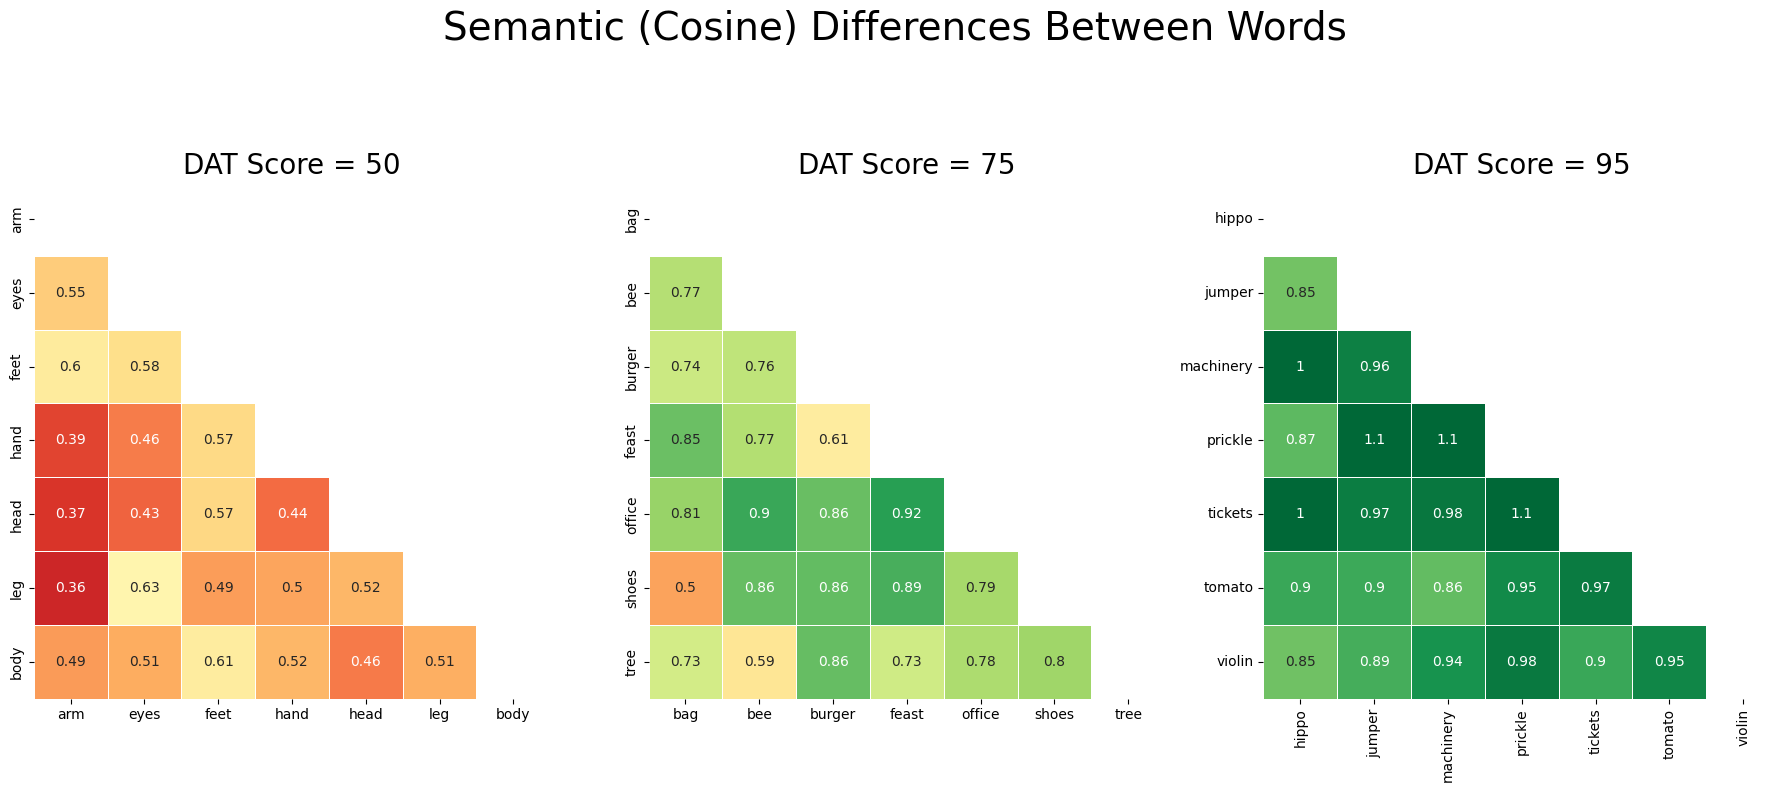

In [212]:
# Define lists of words
lists_of_words = [
    ['arm', 'eyes', 'feet', 'hand', 'head', 'leg', 'body'],
    ["bag", "bee", "burger", "feast", "office", "shoes", "tree"],
    ["hippo", "jumper", "machinery", "prickle", "tickets", "tomato", "violin"]
]

titles = [
    'DAT Score = 50',
    'DAT Score = 75',
    'DAT Score = 95'
]

# Function to compute the distance matrix
def compute_distance_matrix(words, model):
    validated_words = [model.validate(word) for word in words if model.validate(word)]
    distance_matrix = np.zeros((len(validated_words), len(validated_words)))
    for i, word1 in enumerate(validated_words):
        for j, word2 in enumerate(validated_words):
            if i != j:
                distance_matrix[i][j] = model.distance(word1, word2)
    return pd.DataFrame(distance_matrix, index=validated_words, columns=validated_words)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plot each list of words
colormap = 'RdYlGn'  # Choose your colormap here
for ax, words, title in zip(axes, lists_of_words, titles):
    distance_df = compute_distance_matrix(words, model)
    mask = np.triu(np.ones_like(distance_df, dtype=bool))
    sns.heatmap(distance_df, mask=mask, annot=True, cmap=colormap, square=True, linewidths=.5, vmin=0.3, vmax=1, ax=ax, cbar=False)
    ax.set_title(title, fontsize=20)

# Add a big title above all plots
fig.suptitle('Semantic (Cosine) Differences Between Words', fontsize=28)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()